## CNN model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### 模型架構參考:python機器學習與深度學習實作教材範例

In [3]:
input_dim = 28*28
output_dim = 10

In [4]:
x = tf.placeholder("float",[None, input_dim])
y = tf.placeholder("float",[None, output_dim])

In [5]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [6]:
with tf.name_scope('Convolution_layer1'):
    W_conv1 = tf.Variable(tf.random_normal([5, 5, 1, 16]), name='Conv1_weight')
    b_conv1 = tf.Variable(tf.random_normal([16]), name='Conv1_bias')
    
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1))
    
    tf.summary.histogram("conv1", conv1)

with tf.name_scope('Max-pooling_layer1'):
    max_pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    tf.summary.histogram("max_pool1", max_pool1)

In [7]:
with tf.name_scope('Convolution_layer2'):
    W_conv2 = tf.Variable(tf.random_normal([5, 5, 16, 36]), name='Conv2_weight')
    b_conv2 = tf.Variable(tf.random_normal([36]), name='Conv2_bias')
    
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(max_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME'), b_conv2))
    
    tf.summary.histogram("conv2", conv2)
    
with tf.name_scope('Max-pooling_layer2'):
    max_pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    tf.summary.histogram("max_pool2", max_pool2)

In [8]:
with tf.name_scope('Flatten_layer'):
    flatten = tf.reshape(max_pool2, [-1, 7 * 7 * 36])

In [9]:
learning_rate = 0.001
training_epochs = 100
batch_size = 200

In [10]:
MLP_input_dim = 7*7*36
hidden1_dim = 256
hidden2_dim = 256

In [11]:
with tf.name_scope('InputLayer_to_HiddenLayer1'):
    # input layer to hidden layer 1
    w1 = tf.Variable(tf.random_normal([MLP_input_dim, hidden1_dim]),name='weight1')
    b1 = tf.Variable(tf.random_normal([hidden1_dim]),name='bias1')
    a1 = tf.nn.relu(tf.add(tf.matmul(flatten,w1),b1))
    
    # add summary
    tf.summary.histogram("w1", w1)
    tf.summary.histogram("b1", b1)
    tf.summary.histogram("a1", a1)

In [12]:
with tf.name_scope('HiddenLayer1_to_HiddenLayer2'):
    # input layer to hidden layer 2
    w2 = tf.Variable(tf.random_normal([hidden1_dim, hidden2_dim]),name='weight2')
    b2 = tf.Variable(tf.random_normal([hidden2_dim]),name='bias2')
    a2 = tf.nn.relu(tf.add(tf.matmul(a1,w2),b2))
    
    # add summary
    tf.summary.histogram("w2", w2)
    tf.summary.histogram("b2", b2)
    tf.summary.histogram("a2", a2)

In [13]:
with tf.name_scope('HiddenLayer2_to_OutputLayer'):
    # hidden layer 2 to output layer
    w3 = tf.Variable(tf.random_normal([hidden2_dim, output_dim]),name='weight3')
    b3 = tf.Variable(tf.random_normal([output_dim]),name='bias3')
    y_pred = tf.add(tf.matmul(a2,w3),b3)

    # add summary
    tf.summary.histogram("w3", w3)
    tf.summary.histogram("b3", b3)
    tf.summary.histogram("y_pred", y_pred)

In [14]:
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
    tf.summary.scalar("loss", loss)

In [15]:
with tf.name_scope('Accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.summary.scalar("accuracy", accuracy)

In [16]:
with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

In [17]:
merged_summary = tf.summary.merge_all()

In [18]:
losses = []
val_losses = []

saver = tf.train.Saver()

with tf.Session() as sess:
    # 初始化Variables
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("log_cnn/", graph=sess.graph)
    
    global_step = 0
    for epoch in range(training_epochs):
        num_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(num_batch):
            batch_x_train, batch_y_train = mnist.train.next_batch(batch_size)
            batch_x_validation, batch_y_validation = mnist.validation.next_batch(batch_size)
            
            # training by optimizer
            sess.run(optimizer, feed_dict={x: batch_x_train, y: batch_y_train})
            
            # get training/validation loss & acc
            batch_loss = sess.run(loss, feed_dict={x: batch_x_train, y: batch_y_train})
            batch_acc = sess.run(accuracy, feed_dict={x: batch_x_train, y: batch_y_train})
            batch_val_loss = sess.run(loss, feed_dict={x: batch_x_validation, y: batch_y_validation})
            batch_val_acc = sess.run(accuracy, feed_dict={x: batch_x_validation, y: batch_y_validation})
            
            # 紀錄每個batch的summary並加到writer中
            global_step += 1
            result = sess.run(merged_summary, feed_dict={x: batch_x_train, y: batch_y_train})
            writer.add_summary(result,global_step)
        
        losses.append(batch_loss)
        val_losses.append(batch_val_loss)
   
        print("Epoch:", '%d' % (epoch+1), ", loss=", batch_loss, ", acc=", batch_acc,
              ", val_loss=", batch_val_loss, ", val_acc=", batch_val_acc)
        
            
    # Test Dataset
    print ("Test Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    
    #儲存現有模型
    save_path = saver.save(sess,"save_model/cnn_model.ckpt")

Epoch: 1 , loss= 4255.21 , acc= 0.855 , val_loss= 3081.35 , val_acc= 0.885
Epoch: 2 , loss= 1834.16 , acc= 0.925 , val_loss= 2006.36 , val_acc= 0.93
Epoch: 3 , loss= 1699.72 , acc= 0.93 , val_loss= 2039.93 , val_acc= 0.935
Epoch: 4 , loss= 1115.6 , acc= 0.95 , val_loss= 1832.42 , val_acc= 0.935
Epoch: 5 , loss= 996.502 , acc= 0.945 , val_loss= 606.497 , val_acc= 0.97
Epoch: 6 , loss= 1001.92 , acc= 0.94 , val_loss= 1703.74 , val_acc= 0.93
Epoch: 7 , loss= 809.411 , acc= 0.94 , val_loss= 404.843 , val_acc= 0.96
Epoch: 8 , loss= 1002.67 , acc= 0.925 , val_loss= 827.025 , val_acc= 0.96
Epoch: 9 , loss= 467.752 , acc= 0.97 , val_loss= 819.3 , val_acc= 0.965
Epoch: 10 , loss= 439.463 , acc= 0.97 , val_loss= 673.551 , val_acc= 0.965
Epoch: 11 , loss= 598.857 , acc= 0.97 , val_loss= 479.645 , val_acc= 0.975
Epoch: 12 , loss= 261.232 , acc= 0.955 , val_loss= 718.547 , val_acc= 0.96
Epoch: 13 , loss= 314.118 , acc= 0.97 , val_loss= 393.53 , val_acc= 0.98
Epoch: 14 , loss= 102.785 , acc= 0.995 ,

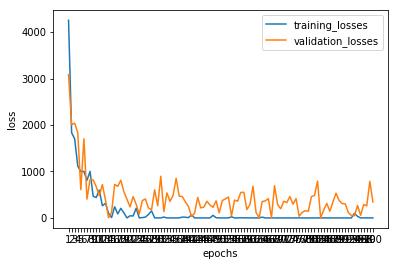

In [19]:
plt.ylabel('loss')
plt.xlabel('epochs')
xtick = [i for i in range(1,len(losses)+1)]
plt.xticks(xtick)
plt.plot(xtick, losses, label='training_losses')
plt.plot(xtick, val_losses, label='validation_losses')
plt.legend()
plt.show()